In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gym # for environment
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam # adaptive momentum 
from keras.callbacks import TensorBoard
import random
import webbrowser

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [7]:
# Registra métricas de entrenamiento en TensorBoard para visualización y depuración
tensorboard_callback = TensorBoard(log_dir = "./logs")

In [8]:
class DQLAgent(): 
    
    def __init__(self, env):
        # parameters and hyperparameters
        
        # this part is for neural network or build_model()
        self.state_size = env.observation_space.shape[0] # this is for input of neural network node size
        self.action_size = env.action_space.n # this is for out of neural network node size
        
        # this part is for replay()
        self.gamma = 0.95
        self.learning_rate = 0.001
        
        # this part is for adaptiveEGreedy()
        self.epsilon = 1 # initial exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        
        self.memory = deque(maxlen = 1000) # a list with 1000 memory, if it becomes full first inputs will be deleted
        
        self.model = self.build_model()
    
    def build_model(self):
        # neural network for deep Q learning
        model = Sequential()
        model.add(Dense(48, input_dim = self.state_size, activation = 'tanh')) # first hidden layer
        model.add(Dense(self.action_size, activation = 'linear')) # output layer
        model.compile(loss = 'mse', optimizer = Adam(learning_rate = self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done):
        # storage
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        # acting, exploit or explore
        if random.uniform(0,1) <= self.epsilon:
            return env.action_space.sample()
        else:
            act_values = self.model.predict(state)
            return np.argmax(act_values[0])
            
    
    def replay(self, batch_size):
        # training
        
        if len(self.memory) < batch_size:
            return # memory is still not full
        
        minibatch = random.sample(self.memory, batch_size) # take 16 (batch_size) random samples from memory
        for state, action, reward, next_state, done in minibatch:
            if done: # if the game is over, I dont have next state, I just have reward 
                target = reward
            else:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0]) 
                # target = R(s,a) + gamma * max Q`(s`,a`)
                # target (max Q` value) is output of Neural Network which takes s` as an input 
                # amax(): flatten the lists (make them 1 list) and take max value
            train_target = self.model.predict(state) # s --> NN --> Q(s,a)=train_target
            train_target[0][action] = target
            self.model.fit(state, train_target, verbose = 0, callbacks=[tensorboard_callback]) # verbose: dont show loss and epoch
    
    def adaptiveEGreedy(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            

if __name__ == "__main__":
    
    # initialize gym environment and agent
    env = gym.make('CartPole-v0')
    agent = DQLAgent(env)

    batch_size = 16
    episodes = 10
    for e in range(episodes):
        
        # initialize environment
        state = env.reset()
        state = np.reshape(state[0], [1,4])
        
        time = 0 # each second I will get reward, because I want to sustain a balance forever
        while True:
            
            # act
            action = agent.act(state)
            
            # step
            next_state, reward, done, _ , _= env.step(action)
            next_state = np.reshape(next_state, [1,4])
            
            # remember / storage
            agent.remember(state, action, reward, next_state, done)
            
            # update state
            state = next_state
            
            # replay
            agent.replay(batch_size)
            
            # adjust epsilon
            agent.adaptiveEGreedy()

            # Creamos un condicional random para guardar el modelo de vez en cuando
            if(random.random() < 0.1):
                agent.model.save('models/cartpole_pruebas.keras')
                print("Model Saved")
            
            time += 1
            
            if done:
                print('episode: {}, time: {}'.format(e, time))
                break
    # Guardamos el modelo entrenado        
    agent.model.save('models/cartpole_pruebas.keras')
    print("Model Saved")


episode: 0, time: 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\maqui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maqui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

In [9]:
# Inicia TensorBoard para visualizar los datos de entrenamiento registrados
!tensorboard --logdir=logs --host localhost --port 8080

# Abre el navegador predeterminado y navega a la URL especificada
webbrowser.open("http://localhost:8080/?darkMode=true#timeseries")

2024-04-14 14:27:02.234474: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-14 14:27:03.007817: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
E0414 14:27:05.428374  7228 program.py:300] TensorBoard could not bind to port 8080, it was already in use
ERROR: TensorBoard could not bind to port 8080, it was already in use


True

Al abrir el navegador esto es lo que se deberia de ver.

PD: Importante poner Horizontal Axis en Relative

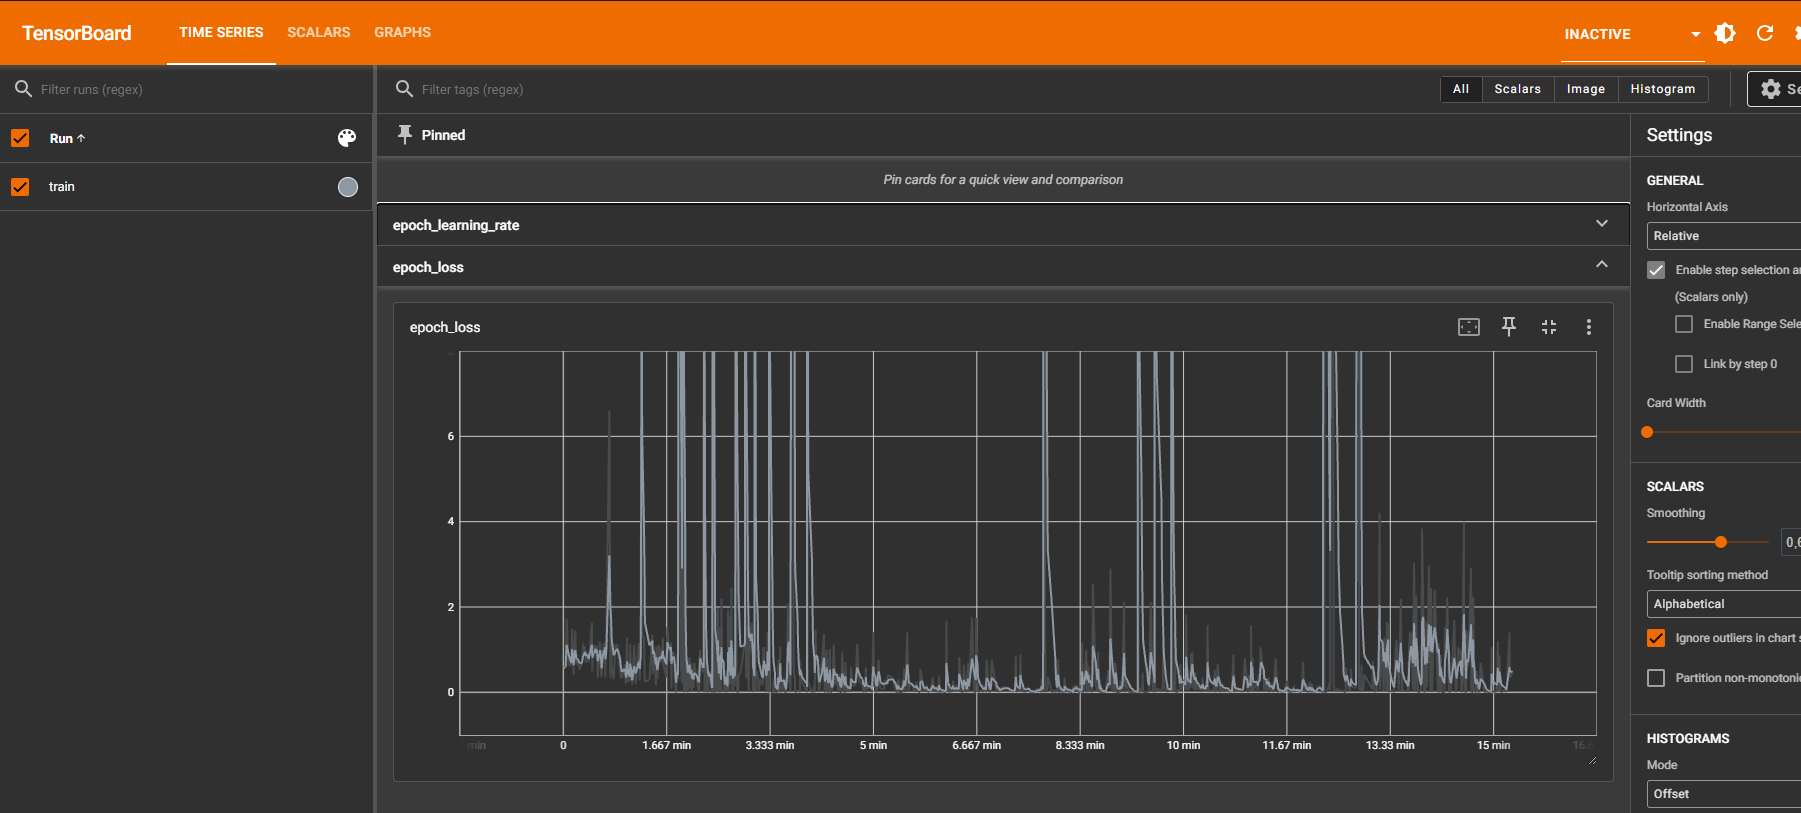

In [10]:
import time
import pandas as pd

n_jugadas = 20

tiempos_recompensas = pd.DataFrame()



for i in range(n_jugadas):
    trained_model = agent

    # Crea un entorno de CartPole y lo renderiza en una ventana
    env = gym.make('CartPole-v0', render_mode='human')

    # Now I have trained agent 
    state = env.reset() 
    # Game will start with inital random state 
    state = np.reshape(state[0], [1,4]) 

    time_t = 0
    total_reward = 0

    while True: 
        env.render() 
        action = trained_model.act(state) 
        next_state, reward, done, _, _ = env.step(action) 
        next_state = np.reshape(next_state, [1,4]) 
        state = next_state 
        total_reward += reward
        time_t += 1 
        print(time_t) 
        time.sleep(0.01) 
        if done: 
            fila = len(tiempos_recompensas)
            tiempos_recompensas.at[fila, "Tiempos (s)"] = time_t
            tiempos_recompensas.at[fila, "Recompensas"] = total_reward
            break
    print('Done')
    
env.close()
print('Finished')

C:\Users\maqui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4


C:\Users\maqui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
11
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
15
16
17
18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
21
22
23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
24
25
26
27
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
28
29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
30
31
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
34
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
39
40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
42
43
44
45
1/1 ━━━━

C:\Users\maqui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
C:\Users\maqui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
10
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13
14
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
17
18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
22
23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
24
25
26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
27
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
29
30
31
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
34
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/s

Al ejecutar el codigo anterior se abrira una ventana en la que se visualizara el cartpole

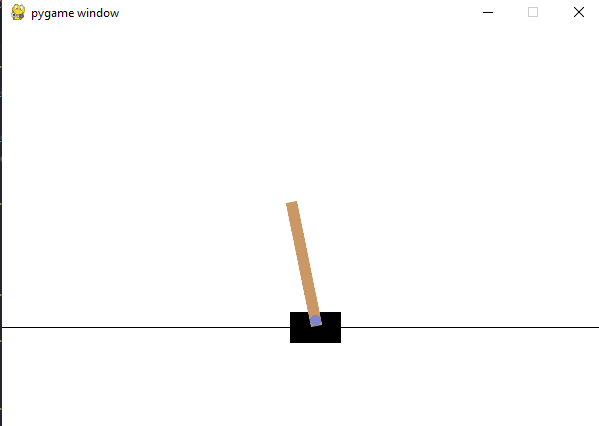

Como esta asignado un punto por segundo, los segundos que dure tiene que coincidir con la recompensa dada

In [11]:
from IPython.display import display

# recompensas en cada jugada
display(tiempos_recompensas.style.hide(axis="index").set_properties(**{'text-align': 'center'}).format("{:.2f}"))

Tiempos (s),Recompensas
61.00,61.00
40.00,40.00
38.00,38.00
64.00,64.00
77.00,77.00
30.00,30.00
28.00,28.00
79.00,79.00
29.00,29.00
30.00,30.00
